In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
window_size = 180
train_ds= ECGDataset(f"data/normal_train_{window_size}.csv", f"data/train_labels_{window_size}.csv")
test_normal_ds = ECGDataset(f"data/normal_test{window_size}.csv", f"data/normal_labels_{window_size}.csv")
test_anomalie_ds = ECGDataset(f"data/anomalie_test{window_size}.csv", f"data/anomalie_labels_{window_size}.csv")
val_ds = ECGDataset(f"data/normal_val_{window_size}.csv", f"data/val_labels_{window_size}.csv")


In [4]:
train_ds.y

[['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],


['N']

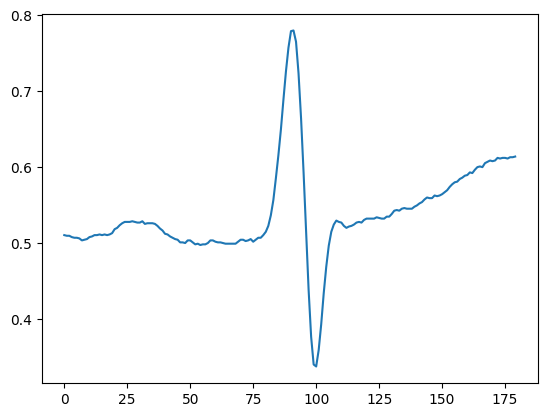

In [5]:
plt.plot(train_ds.df[0])
train_ds.y[0]

In [6]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, (X,y) in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X).unsqueeze(0)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for (seq_true, y) in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true).unsqueeze(0)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [10]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 64)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=8,
  lr=3e-4,
  batch_size=1
)

loss: 59.385319  [    1/71253]
loss: 25.947453  [10001/71253]
loss: 12.433839  [20001/71253]
loss: 6.645082  [30001/71253]
loss: 5.241090  [40001/71253]
loss: 13.620543  [50001/71253]
loss: 6.198558  [60001/71253]
loss: 5.409899  [70001/71253]
Epoch 1: train loss = 10.633872762764737, val loss = 7.327059471899284
loss: 5.241003  [    1/71253]
loss: 6.524369  [10001/71253]
loss: 3.892651  [20001/71253]
loss: 6.087968  [30001/71253]
loss: 6.736009  [40001/71253]
loss: 3.175680  [50001/71253]
loss: 2.275985  [60001/71253]
loss: 2.071966  [70001/71253]
Epoch 2: train loss = 6.0167702973602495, val loss = 4.179949318633955
loss: 2.984911  [    1/71253]
loss: 3.134208  [10001/71253]
loss: 4.607507  [20001/71253]
loss: 3.356690  [30001/71253]
loss: 2.372802  [40001/71253]
loss: 1.875727  [50001/71253]
loss: 3.513137  [60001/71253]
loss: 2.729237  [70001/71253]
Epoch 3: train loss = 2.886152774653913, val loss = 2.4545492237642215
loss: 3.013679  [    1/71253]
loss: 1.220989  [10001/71253]
los

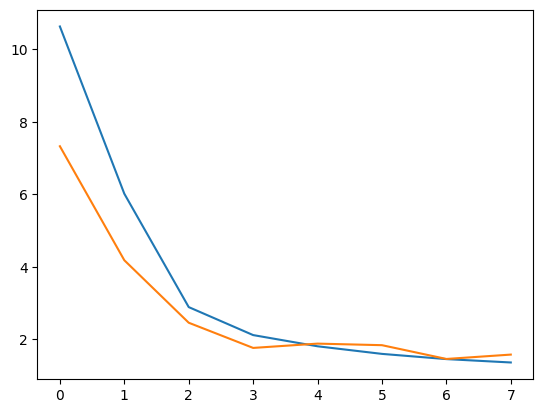

In [12]:
plt.plot(history["train"])
plt.plot(history["val"])

In [13]:
torch.save(model.state_dict(), "models/lstmae_180.pth")

In [12]:
model.load_state_dict(torch.load("models/lstmae_5000.pth", map_location=torch.device('cpu')))
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [20]:
model = model.to(device=device)

In [15]:
train_ds.__getitem__(0)

(tensor([[0.5104],
         [0.5096],
         [0.5096],
         [0.5078],
         [0.5070],
         [0.5070],
         [0.5061],
         [0.5035],
         [0.5043],
         [0.5052],
         [0.5078],
         [0.5087],
         [0.5104],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5130],
         [0.5183],
         [0.5200],
         [0.5235],
         [0.5261],
         [0.5278],
         [0.5278],
         [0.5278],
         [0.5287],
         [0.5278],
         [0.5270],
         [0.5270],
         [0.5287],
         [0.5252],
         [0.5261],
         [0.5261],
         [0.5261],
         [0.5252],
         [0.5226],
         [0.5191],
         [0.5165],
         [0.5122],
         [0.5113],
         [0.5087],
         [0.5070],
         [0.5052],
         [0.5043],
         [0.5009],
         [0.5009],
         [0.5000],
         [0.5035],
         [0.5035],
         [0.5009],
         [0.

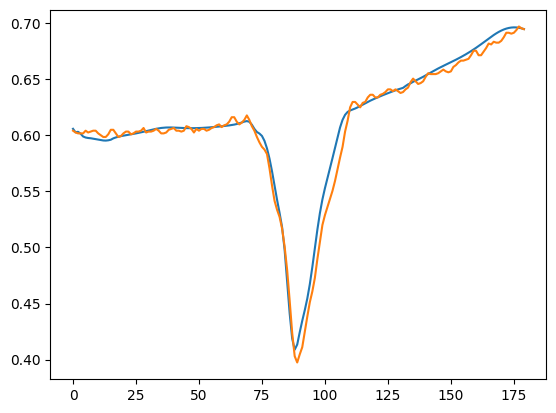

In [17]:
plt.plot(model(test_normal_ds.__getitem__(2233)[0]).cpu().detach().numpy().squeeze())
plt.plot(test_normal_ds.__getitem__(2233)[0].cpu().detach().numpy().squeeze())

In [18]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [21]:
_, losses_test_normal = predict(model, test_normal_ds)

(array([6.700e+01, 3.950e+02, 1.012e+03, 1.263e+03, 1.334e+03, 1.101e+03,
        8.750e+02, 6.720e+02, 5.650e+02, 4.100e+02, 3.040e+02, 2.470e+02,
        1.690e+02, 1.090e+02, 6.600e+01, 3.800e+01, 3.300e+01, 1.600e+01,
        2.000e+01, 1.100e+01, 1.500e+01, 8.000e+00, 7.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 5.000e+00,
        0.000e+00, 4.000e+00, 5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

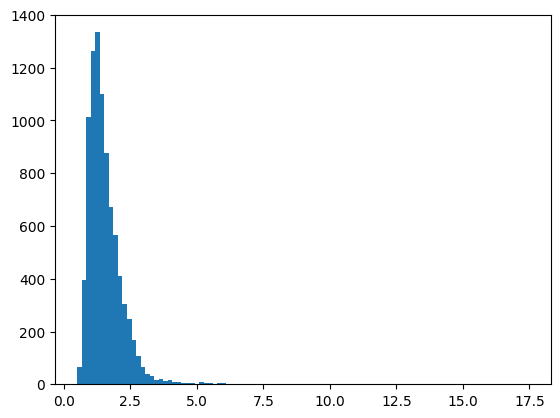

In [45]:
plt.hist(losses_test_normal, bins=100)

In [50]:
THRESHOLD = 2.5

In [51]:
correct = sum(l <= THRESHOLD for l in losses_test_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_ds)} or  {correct/len(test_normal_ds)}')

Correct normal predictions: 8189/8797 or  0.9308855291576674


In [25]:
_, losses_test_anomaly = predict(model, test_anomalie_ds)

(array([1.444e+03, 3.947e+03, 4.127e+03, 2.698e+03, 1.538e+03, 1.237e+03,
        1.380e+03, 7.330e+02, 9.250e+02, 8.660e+02, 7.030e+02, 4.640e+02,
        2.620e+02, 1.290e+02, 9.900e+01, 1.250e+02, 2.400e+02, 1.740e+02,
        7.400e+01, 7.600e+01, 5.400e+01, 1.100e+01, 4.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 0.55636758,  1.68957647,  2.82278536,  3.95599425,  5.08920314,
         6.22241203,  7.35562092,  8.48882981,  9.62203871, 10.7552476 ,
        11.88845649, 13.02166538, 14.15487427, 15.28808316, 16.42129205,
        17.55450094, 18.68770983, 19.82091873, 20.95412762, 22.08733651,
        23.2205454 , 24.35375429, 25.48696318, 26.62017207, 27.75338096,
        28.

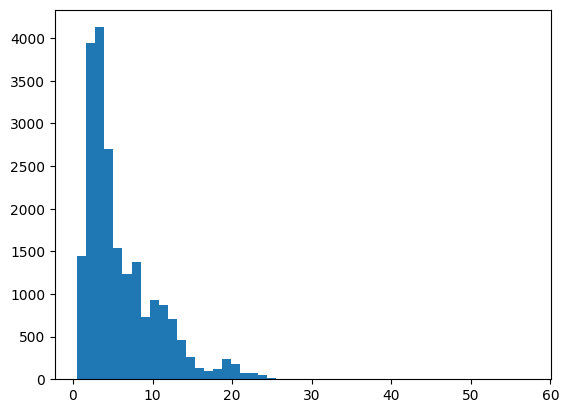

In [34]:
plt.hist(losses_test_anomaly, bins=50)

In [53]:
correct = sum(l > THRESHOLD for l in losses_test_anomaly)
print(f'Correct anomaly predictions: {correct}/{len(test_anomalie_ds)} or  {correct/len(test_anomalie_ds)}')

Correct anomaly predictions: 17192/21326 or  0.8061521147894589


array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [71]:
def find_threshold(loss_normal, loss_anomaly):
    threshold_list = np.linspace(0,5,21)
    corr_normal = []
    corr_anomaly = []
    for th in threshold_list:
        corr_normal.append(sum(l <= th for l in loss_normal)/len(loss_normal))
        corr_anomaly.append(sum(l > th for l in loss_anomaly)/len(loss_anomaly))
    return corr_normal, corr_anomaly

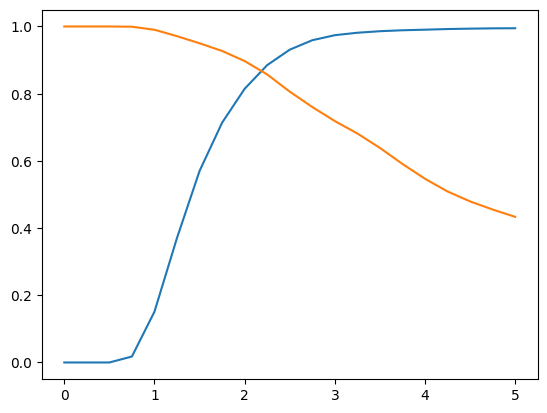

In [72]:
p1, p2= find_threshold(losses_test_normal, losses_test_anomaly)
plt.plot(np.linspace(0,5,21), p1)
plt.plot(np.linspace(0,5,21), p2)

In [76]:
def predict_classes(model, dataset, threshold=2.25):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            pred = "N" if loss <= threshold else "A"
            predictions.append(pred)
            losses.append(loss.item())
    return predictions

In [77]:
from sklearn import metrics
    
pred_normal = predict_classes(model, test_normal_ds)
pred_anomaly = predict_classes(model, test_anomalie_ds)

In [87]:
pred_anomaly

['N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'N',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A'

In [92]:
print(f"Acc: {metrics.accuracy_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly)}")
print(f"Precision: {metrics.precision_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"Recall: {metrics.recall_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"F1: {metrics.f1_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")

Acc: 0.8653520565680709
Precision: 0.7189029457937021
Recall: 0.8849607820848017
F1: 0.7933353714460409
